# Lecture 3 - Build a decision tree model from the lung dataset

## Consider the *lung* data set available form the EPI7913A package
### Load the lung data set form last class and remove the two categorical columns we added last time!

In [1]:
clung <- epi7913A::lung

# clean up – remove the extra columns we add last class!
# and make a copy of data to clung and remove and rows that contain NA
clung <- clung[,-11:-12]
clung <- clung[complete.cases(clung),]
head(clung)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2,3,455,2,68,1,0,90,90,1225,15
4,5,210,2,57,1,1,90,60,1150,11
6,12,1022,1,74,1,1,50,80,513,0
7,7,310,2,68,2,2,70,60,384,10
8,11,361,2,71,2,2,60,80,538,1
9,1,218,2,53,1,1,70,80,825,16


## Build a classification and regression tree (CART) model from the lung dataset

## Initialize variables and define the outcome binary column *alive_at_cutoff*

In [2]:
# initialize parameters for the experiment
train_data_split = 0.6   # 0.6 for training and 1-0.6 for testing
iterations = 1000        # 1000 repeated runs
survival_cutoff = 365    #survival cutoff is 1 year = 365 days

# construct the outcome columns of 1 for those who survive on or above 
# the cutoff value
clung <- within(clung, { 
  alive_at_cutoff <- NA; #initialize a new column
  alive_at_cutoff[time >= survival_cutoff] <- 1
  alive_at_cutoff[time < survival_cutoff ] <- 0 
} )
clung$alive_at_cutoff <- as.factor(clung$alive_at_cutoff)
# levels(clung$alive_at_cutoff) = c("No","Yes") # this will break this code! Why?

head(clung)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,alive_at_cutoff
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
2,3,455,2,68,1,0,90,90,1225,15,1
4,5,210,2,57,1,1,90,60,1150,11,0
6,12,1022,1,74,1,1,50,80,513,0,1
7,7,310,2,68,2,2,70,60,384,10,0
8,11,361,2,71,2,2,60,80,538,1,0
9,1,218,2,53,1,1,70,80,825,16,0


## Set the random seed and define a new matrix to capture the results

In [3]:
# set the random seed for reproducibility 
set.seed(17) 

# allocate a matrix to capture the logloss values for each iteration of the experiment
evaluation_results = matrix(NA,nrow=iterations, ncol=2)
colnames(evaluation_results) <- c("logLoss_train", "logLoss_test")

head(clung)
head(evaluation_results)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,alive_at_cutoff
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
2,3,455,2,68,1,0,90,90,1225,15,1
4,5,210,2,57,1,1,90,60,1150,11,0
6,12,1022,1,74,1,1,50,80,513,0,1
7,7,310,2,68,2,2,70,60,384,10,0
8,11,361,2,71,2,2,60,80,538,1,0
9,1,218,2,53,1,1,70,80,825,16,0


logLoss_train,logLoss_test
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA


## The main body of the loop over train/test data

### For the number of iterations:
  - ### Partition *clung* into train and test portions as defined by train_data_split and stratified to the ratio of *Yes:No* in alive_at_cutoff
  - ### Retrieve train and test data
  - ### Construct a decision tree classification model   
  - ### Make probability predictions on training data
  - ### Calculate the log loss of predicted probabilities to actual values in training data (find goodness of fit)
  - ### Using the resulting model, predict the probabilities on the test data
  - ### Calculate how well predicted probabilities fit actual values for test data
  - ### Record the goodness of fit on training and logloss on test

In [6]:

# for the number of iterations:
for (i in 1:iterations) {
    
    #     partition clung into train and test portions as defined by train_data_split and stratified to the ratio of Yes:No in alive_at_cutoff
    inds <- splitTools::partition(clung$alive_at_cutoff, p = c(train = train_data_split, test = (1 - train_data_split)))
    
    #     retrieve train and test data
    train <- clung[inds$train, ]
    test  <- clung[inds$test, ]
    
    # construct a decision tree classification model   
    tree_model <- rpart::rpart(alive_at_cutoff ~ age + sex + meal.cal + wt.loss, data = train, method = "class")
    
    # make probability predictions on training data
    tree_predictions <- predict(tree_model, train, type = 'prob')
    
    # calculate the log loss of predicted probabilities to actual values in training data (find goodness of fit)
    r1 <- MLmetrics::LogLoss(tree_predictions[,2], as.numeric(as.character(train$alive_at_cutoff)))
    
    # using the resulting model, predict the probabilities on the test data
    tree_predictions <- predict(tree_model, test, type = 'prob')
    
    # calculate how well predicted probabilities fit actual values for test data
    r2 <- MLmetrics::LogLoss(tree_predictions[,2], as.numeric(as.character(test$alive_at_cutoff)))
    
    # record the goodness of fit on training and logloss on test
    evaluation_results[i,] <- c(r1,r2)
  }

head(evaluation_results)

logLoss_train,logLoss_test
0.5207197,0.7144065
0.5312308,0.7207620
0.6021517,0.6097691
0.5001069,2.0786056
0.5505285,0.6390767
0.5222878,0.8736616


In [7]:
tree_predictions


,0,1
8,0.7916667,0.20833333
15,0.8888889,0.11111111
17,0.7333333,0.26666667
19,0.7916667,0.20833333
21,0.7333333,0.26666667
22,0.9166667,0.08333333
24,0.2222222,0.77777778
27,0.9166667,0.08333333
32,0.7916667,0.20833333
34,0.6153846,0.38461538


### Plot the boxplot of logLoss collected over the runs.

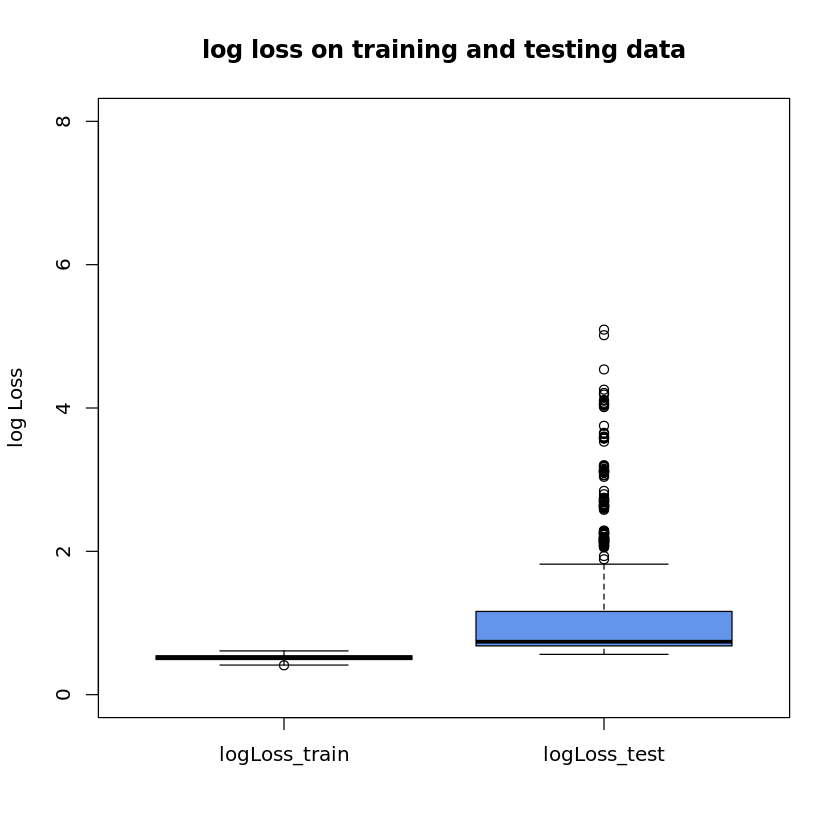

In [8]:
  # plot box plots of log los values on training and on testing
  boxplot(evaluation_results, ylim=c(0,8), col = c("cornsilk","cornflowerblue"), 
          ylab = "log Loss", main = "log loss on training and testing data")

### Plot the decision tree itself -- requires rpart.plot

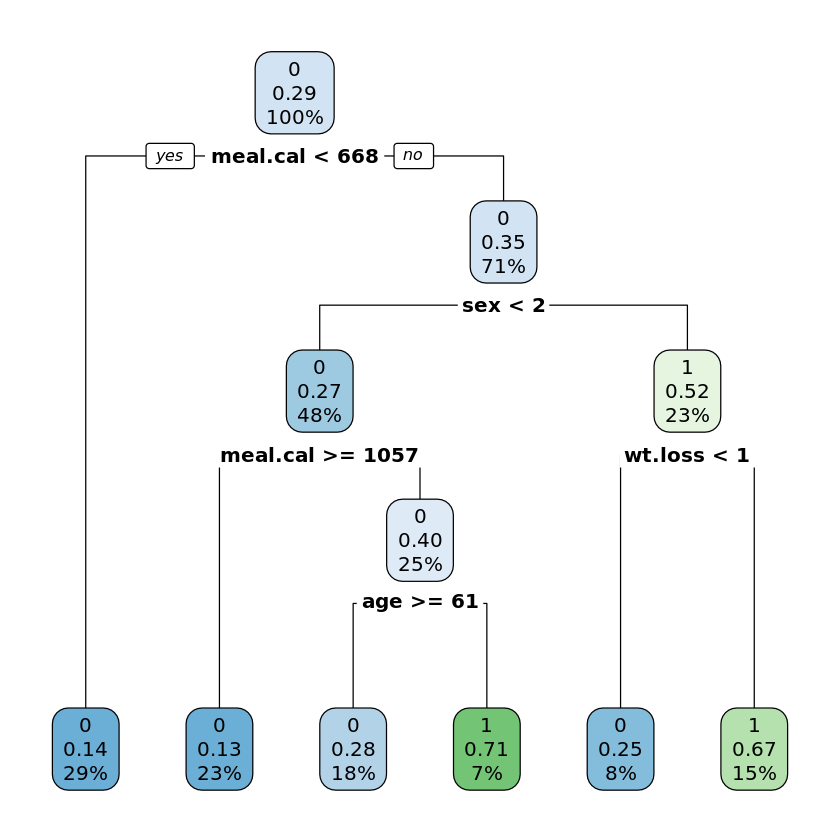

In [6]:
# plot the last decision tree
rpart.plot::rpart.plot(tree_model)

### Examine the complexity parameter of the tree -- used to determine the splits

In [7]:
# show complexity parameter of the decision tree
rpart::printcp(tree_model)


Classification tree:
rpart::rpart(formula = alive_at_cutoff ~ age + sex + meal.cal + 
    wt.loss, data = train, method = "class")

Variables actually used in tree construction:
[1] age      meal.cal sex      wt.loss 

Root node error: 29/100 = 0.29

n= 100 

        CP nsplit rel error xerror    xstd
1 0.057471      0   1.00000 1.0000 0.15647
2 0.051724      3   0.82759 1.2069 0.16447
3 0.010000      5   0.72414 1.4828 0.17072


### Plot the Complexity Parameter Graph to visualize it

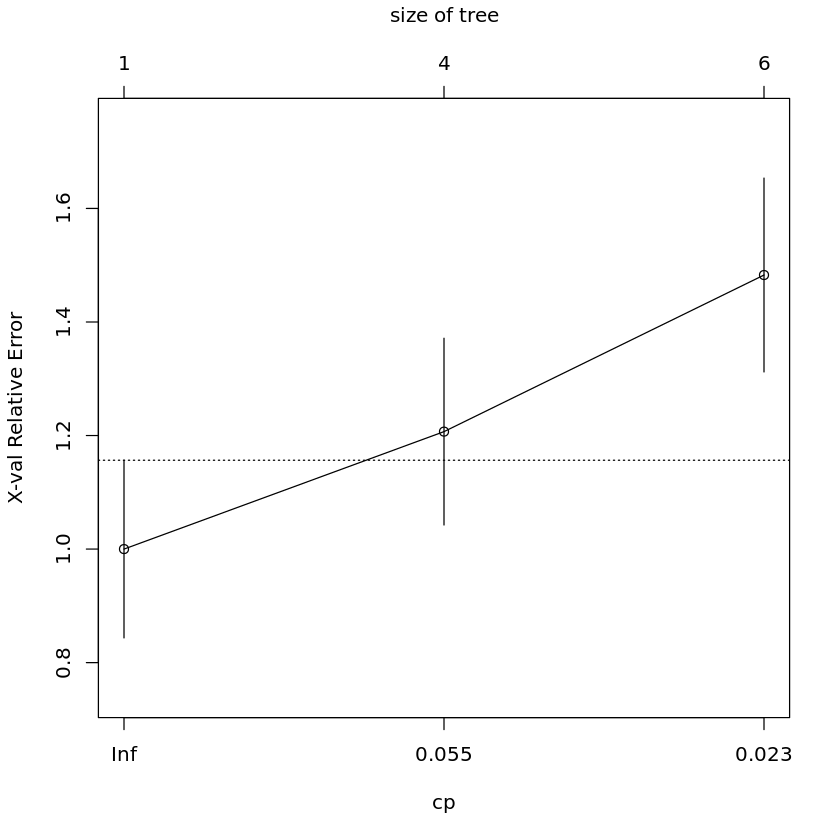

In [8]:
# plot complexity graph
rpart::plotcp(tree_model)

### Prune the tree with the best CP value that minimizes the error

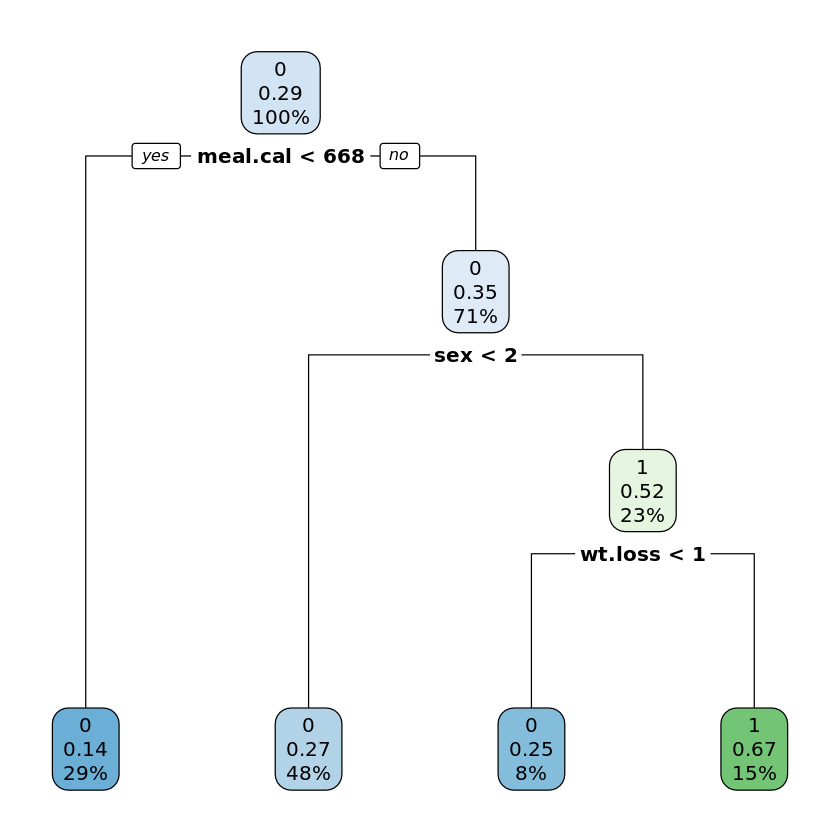

In [9]:
# prune the tree at specific cp value
pruned_tree_model <- rpart::prune(tree_model,0.052)

# plot the pruned decision tree
rpart.plot::rpart.plot(pruned_tree_model)

### Repeat the experiment using the pruned tree

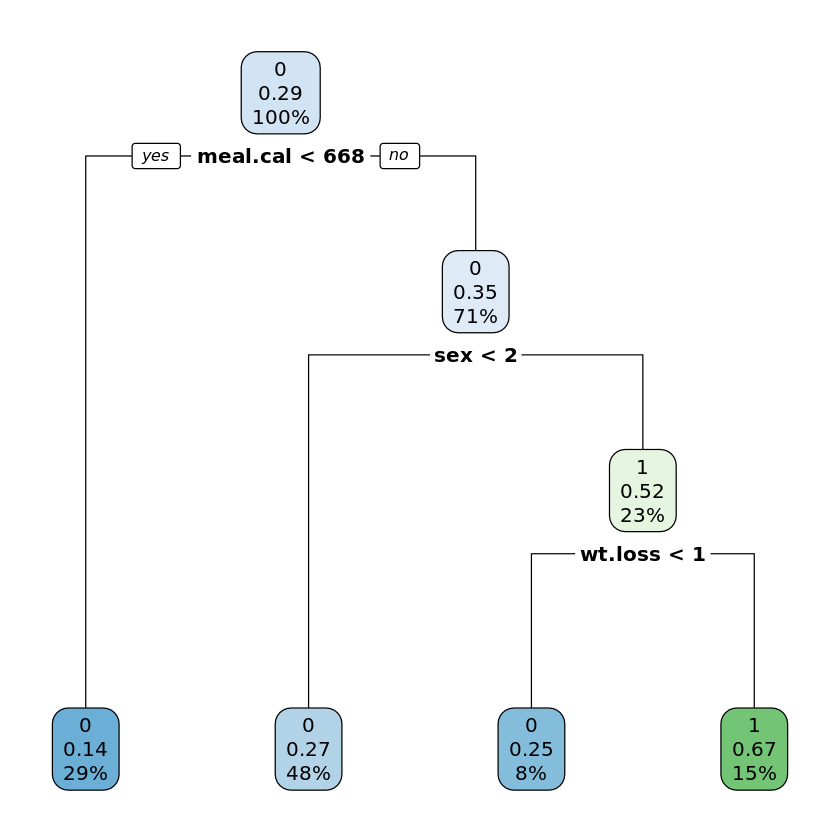

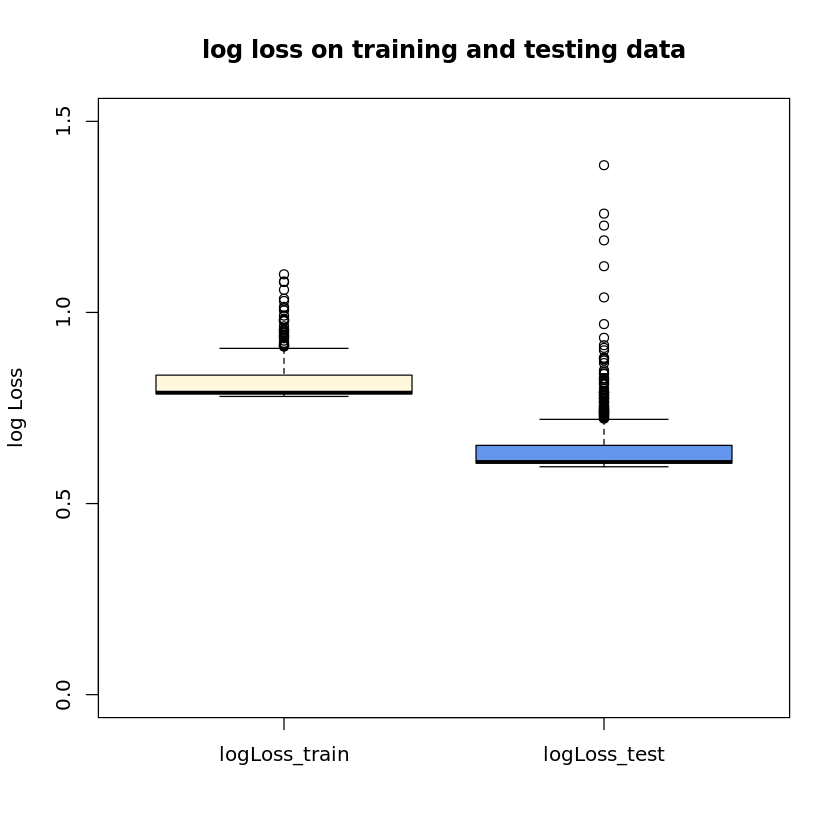

In [9]:
# reset the random seed for reproducibility 
set.seed(17)

# allocate a matrix to capture the logloss values for each iteration of the experiment
evaluation_results = matrix(NA,nrow=iterations, ncol=2)
colnames(evaluation_results) <- c("logLoss_train", "logLoss_test")

# for the number of iterations:
for (i in 1:iterations) {
  
  #     partition clung into train and test portions as defined by train_data_split and stratified to the ratio of Yes:No in alive_at_cutoff
  inds <- splitTools::partition(clung$alive_at_cutoff, p = c(train = train_data_split, test = (1 - train_data_split)))
  
  #     retrieve train and test data
  train <- clung[inds$train, ]
  test  <- clung[inds$test, ]
  
  # construct a generalizable linear model from "alive_at_cutoff ~ age + sex" using a binomial logistic model  
  pruned_tree_model <- rpart::rpart(alive_at_cutoff ~ age + sex + meal.cal + wt.loss, data = train, method = "class", cp = 0.052)
    
  # make predictions on training data
  pruned_tree_predictions <- predict(pruned_tree_model, train, type = 'prob')
  
  # calculate the log loss of predicted probabilities to actual values in training data (find goodness of fit)
  r1 <- MLmetrics::LogLoss(pruned_tree_predictions[,], as.numeric(as.character(train$alive_at_cutoff)))
  
  # using th resulting model, predict the probabilities on the test data
  pruned_tree_predictions <- predict(pruned_tree_model, test, type = 'prob')
  
  # calculate how well predicted probabilities fit actual values for test data
  r2 <- MLmetrics::LogLoss(pruned_tree_predictions[,2], as.numeric(as.character(test$alive_at_cutoff)))
  
  # record the goodness of fit on training and logloss on test
  evaluation_results[i,] <- rbind(r1,r2)
}

rpart.plot::rpart.plot(pruned_tree_model)

# plot box plots of log loss values on training and on testing
boxplot(evaluation_results, ylim=c(0,1.5), col = c("cornsilk","cornflowerblue"), 
        ylab = "log Loss", main = "log loss on training and testing data")